In [1]:
import os
import pickle
import numpy as np 
# --- astropy ---
from astropy.table import Table
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
from provabgs import infer as Infer
from provabgs import models as Models

In [3]:
from desitarget.sv3.sv3_targetmask import desi_mask as sv3_desi_mask

# read in SV3 data
only keep BGS galaxies with solid redshifts: 
- ZWARN = 0 
- DELTACHI2 > 40
- SPECTYPE != 'STAR'
- 0 < Z < 0.6
- ZERR < 0.0005 * (1+Z)

In [4]:
fsv3 = '/Users/chahah/data/provabgs/sv3.20210420.BGS_ANYALLtiles_full.fits'
sv3 = Table.read(fsv3)

Text(0, 0.5, 'DEC')

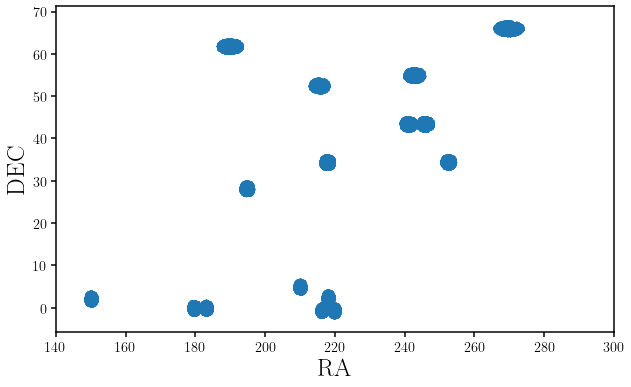

In [5]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.scatter(sv3['RA'], sv3['DEC'], s=1, c='C0')
sub.set_xlabel('RA', fontsize=25)
sub.set_xlim(140, 300)
sub.set_ylabel('DEC', fontsize=25)

In [6]:
zcuts = ((sv3['ZWARN'] == 0) & 
         (sv3['DELTACHI2'] > 40.) & 
         (sv3['SPECTYPE'] != 'STAR') & 
         (sv3['Z'] > 0) & 
         (sv3['Z'] < 0.6) & 
         (sv3['ZERR'] < 0.0005 * (1 + sv3['Z'])))

is_bgs = (sv3['SV3_DESI_TARGET'] & sv3_desi_mask['BGS_ANY']) != 0
cuts = zcuts & is_bgs

In [7]:
sv3_bgs = sv3[cuts]
sv3_bgs.write('/Users/chahah/data/provabgs/sv3.20210420.bgs_clean.fits', overwrite=True)

In [8]:
print('%i BGS galaxies' % len(sv3_bgs))

144880 BGS galaxies


In [9]:
sv3_gflux = sv3_bgs['FLUX_G']
sv3_rflux = sv3_bgs['FLUX_R']
sv3_zflux = sv3_bgs['FLUX_Z']

sv3_gflux_ivar = sv3_bgs['FLUX_IVAR_G']
sv3_rflux_ivar = sv3_bgs['FLUX_IVAR_R']
sv3_zflux_ivar = sv3_bgs['FLUX_IVAR_Z']

sv3_gmag = 22.5 - 2.5*np.log10(sv3_gflux.clip(1e-16))
sv3_rmag = 22.5 - 2.5*np.log10(sv3_rflux.clip(1e-16))
sv3_zmag = 22.5 - 2.5*np.log10(sv3_zflux.clip(1e-16))

sv3_z = sv3_bgs['Z']

(-1.0, 2.0)

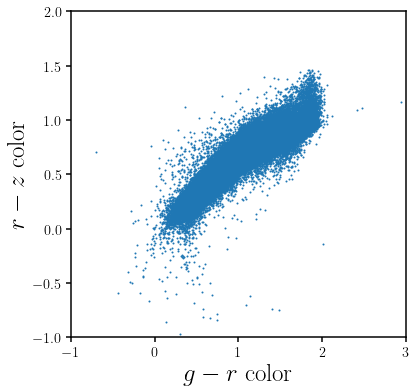

In [10]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(sv3_gmag - sv3_rmag, sv3_rmag - sv3_zmag, c='C0', s=1)
sub.set_xlabel('$g-r$ color', fontsize=25)
sub.set_xlim(-1, 3)
sub.set_ylabel('$r-z$ color', fontsize=25)
sub.set_ylim(-1, 2)

# infer galaxy properties using `provabgs`
We will the standard prior: 
- uniform prior on $M_*$, $f_{\rm burst}$, $t_{\rm burst}$, $\gamma_1$, $\gamma_2$, $\tau_1$, $\tau_2$, $\delta_{\rm dust}$
- dirichlet prior on SFH basis coefficients $\beta_1, \beta_2, \beta_3, \beta_4$

and the `Models.NMF` with the emulator

In [11]:
prior = Infer.load_priors([
    Infer.UniformPrior(9., 12., label='sed'), 
    Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
    Infer.UniformPrior(0., 1., label='sed'), # burst fraction
    Infer.UniformPrior(0., 13.27, label='sed'), # tburst
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
    Infer.UniformPrior(-2.2, 0.4, label='sed')      # uniform priors on dust_index 
])

m_nmf = Models.NMF(burst=True, emulator=True)

In [12]:
desi_mcmc = Infer.desiMCMC(
    model=m_nmf, 
    prior=prior
)

In [13]:
for i in range(1,10): 
    flux_obs = np.array([sv3_gflux[i], sv3_rflux[i], sv3_zflux[i]])
    ivar_obs = np.array([sv3_gflux_ivar[i], sv3_rflux_ivar[i], sv3_zflux_ivar[i]])
    z_obs = sv3_z[i]
    print('r_mag = %.2f, z=%.2f' % (sv3_rmag[i], z_obs))
    
    mcmc_chain = desi_mcmc.run(
        bands='desi', 
        photo_obs=flux_obs, 
        photo_ivar_obs=ivar_obs, 
        zred=z_obs, 
        vdisp=0,
        sampler='zeus',
        nwalkers=30, 
        burnin=0,
        opt_maxiter=2000,
        niter=2000, 
        debug=True)
    pickle.dump(mcmc_chain, open('/Users/chahah/data/provabgs/sv3.20210420.bgs_clean.%i.mcmc.p' % i, 'wb'))

r_mag = 20.33, z=0.28
--- initializing the walkers ---


/Users/chahah/projects/provabgs/src/provabgs/models.py:909: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1520: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  integrand = integrand[values_slice]
/Users/chahah/proj

initial theta = [10.282703079915674, 0.7967313754307195, 0.9999999268213304, 0.15868432015903064, 0.2561955625834628, 2.893808908875874, 0.0034720675183303154, 0.005882478202414659, 1.6855625264939649, 0.19863757181015623, -0.7111581776236637]
log Posterior(theta0) = -9.688613
--- running MCMC ---


Sampling progress : 100%|██████████| 2000/2000 [25:07<00:00,  1.33it/s]


bestfit theta = [10.432984527287294, 0.16664855558316694, 0.1957522936462717, 0.6132342850649015, 0.024364865705659874, 0.18646196442268168, 9.435335706029436, 0.00581136149125197, 0.0009944152405016804, 0.2995178807069942, 0.6470788230601612, -0.6390967021632078]
log Posterior = -0.002833
Model.sed: redshift = 0.278571
Model.sed: ssp lum [ 611313.10129024  618748.2907006   606494.84725717 ... 1082577.23377371
 1074189.45784904 1072841.60080637]
r_mag = 20.14, z=0.28
--- initializing the walkers ---


Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/2000 [00:00<?, ?it/s]

initial theta = [10.809382059881573, 0.6818237850463207, 0.9816474926937392, 0.44908529482657045, 0.424204057733671, 13.269959426679033, 6.900070131359574e-05, 0.0005862554408882583, 1.5302019772854059, 0.7754805281357737, -0.3200216700908228]
log Posterior(theta0) = -0.007949
--- running MCMC ---


Sampling progress : 100%|██████████| 2000/2000 [22:14<00:00,  1.50it/s]


bestfit theta = [10.58895780517782, 0.1862249045267843, 0.23166975954156663, 0.20969524023148145, 0.3724100957001676, 0.007565367726499284, 9.159500546314385, 0.0033628130938189844, 0.0004404222670711498, 0.25266639648559885, 0.43893530334730496, -0.9157669721114473]
log Posterior = -0.000653
Model.sed: redshift = 0.276544
Model.sed: ssp lum [ 513014.12132408  519774.12357894  507718.41525824 ... 1193967.70068537
 1185690.76347263 1184026.70027364]
r_mag = 18.77, z=0.28
--- initializing the walkers ---


Initialising ensemble of 30 walkers...


initial theta = [11.154990706282852, 0.8787839453270132, 0.9996703678500096, 0.11498644055335158, 0.3961081639850015, 2.1773026435269216, 0.006081638775521821, 6.900032030767881e-05, 1.8070686658303199, 0.7112816158263613, -0.6162248278437743]
log Posterior(theta0) = -5.233305
--- running MCMC ---


Sampling progress : 100%|██████████| 2000/2000 [34:41<00:00,  1.04s/it]


bestfit theta = [11.412320845361851, 0.26305036700193296, 0.19487253628503565, 0.27415257368159435, 0.26792452303143705, 0.4290651583246547, 5.125434946286001, 0.0032862318316547803, 0.005726605613401458, 1.2958213643583842, 0.6814991800698037, -0.2801350075833245]
log Posterior = -0.000390
Model.sed: redshift = 0.277888
Model.sed: ssp lum [ 864452.04833648  841706.55187961  728179.83904207 ... 6658905.93944114
 6577629.88408708 6550517.96497492]
r_mag = 19.96, z=0.28
--- initializing the walkers ---


Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/2000 [00:00<?, ?it/s]

initial theta = [10.853984912101428, 0.8838394425441763, 0.4323004150408563, 0.35737488000453854, 0.42507295373345033, 10.497928253762453, 0.003744822025704529, 0.0032971321189811846, 2.1530199734436906, 0.36926392952510245, -1.235923800620089]
log Posterior(theta0) = -0.149924
--- running MCMC ---


Sampling progress : 100%|██████████| 2000/2000 [30:35<00:00,  1.09it/s]


bestfit theta = [10.866474721129656, 0.029109131076945904, 0.6456699714908796, 0.27128126741945313, 0.0539396300127213, 0.6430459176781708, 6.052607363600235, 0.004973360855627318, 0.0024039567408411047, 2.1783108227227985, 0.3543183597743213, -0.824721622258159]
log Posterior = -0.001031
Model.sed: redshift = 0.276533
Model.sed: ssp lum [ 126720.94536733  120263.38298556   95000.50619996 ... 1919606.85127858
 1893873.46190863 1884517.63332157]
r_mag = 19.78, z=0.28
--- initializing the walkers ---


Initialising ensemble of 30 walkers...


initial theta = [10.955278539745468, 0.4869471091158254, 0.4737784454880112, 0.501356827932798, 0.554202382670586, 4.240898827337016, 0.004394310933194427, 0.004570300327814135, 1.7324550045697449, 0.3496049936485881, -0.8045134274321812]
log Posterior(theta0) = -0.000000
--- running MCMC ---


Sampling progress : 100%|██████████| 2000/2000 [33:27<00:00,  1.00s/it]


bestfit theta = [10.955119257551152, 0.5131846956226358, 0.25632917678252926, 0.11491199296184382, 0.11557413463299115, 0.5544806792336794, 4.239423113889265, 0.0043915972603413775, 0.004573195112049443, 1.7319012005849004, 0.3492220894345638, -0.8064762791962555]
log Posterior = -0.000221
Model.sed: redshift = 0.277974
Model.sed: ssp lum [ 111541.58933644  105149.59230234   85681.17601928 ... 2539141.59052554
 2499718.53993853 2482353.67447066]
r_mag = 18.74, z=0.17
--- initializing the walkers ---


Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/2000 [00:00<?, ?it/s]

initial theta = [10.394483917183246, 0.9999999747869159, 0.7852493350748002, 0.31059413632289845, 0.3072988381060576, 11.572773226300637, 0.002089820905719109, 0.0017226865534651164, 0.9093079108699318, 7.560378250226826e-07, -0.3366266237954548]
log Posterior(theta0) = -16.279891
--- running MCMC ---


Sampling progress : 100%|██████████| 2000/2000 [24:41<00:00,  1.35it/s]


bestfit theta = [10.255369232463885, 0.0849561070521766, 0.0007687583329177436, 0.7851265293004228, 0.12914860531448286, 0.04766683409017658, 5.658676078547935, 0.006109150680008609, 0.0004640422704792463, 1.245625949499633, 0.007506597076869352, -0.3722039038695114]
log Posterior = -0.002878
Model.sed: redshift = 0.174198
Model.sed: ssp lum [1815428.79964903 1748080.16382544 1499719.10202061 ... 1019884.37561427
 1011444.1195925  1009195.76098945]
r_mag = 19.28, z=0.32
--- initializing the walkers ---


Initialising ensemble of 30 walkers...


initial theta = [11.16640502375581, 0.4146570540665192, 0.4783573214098388, 0.6169500610776942, 0.42518165225393345, 3.1063503194511846, 0.004758906562500771, 6.900235275929881e-05, 2.7641170878579793, 0.24109530338767832, -1.1214224601665146]
log Posterior(theta0) = -4.186994
--- running MCMC ---


Sampling progress : 100%|██████████| 2000/2000 [35:19<00:00,  1.06s/it]


bestfit theta = [11.050995279864303, 0.4487959926752547, 0.4133073352013068, 0.026987477913669202, 0.11090919420976925, 0.4540656663022366, 2.8708322724932365, 0.0009784378257936663, 0.00038900634512252275, 2.2457660715876475, 0.24152792319523725, -1.769910807988315]
log Posterior = -0.001381
Model.sed: redshift = 0.317599
Model.sed: ssp lum [  69713.8778539    71589.13948529   62257.07168329 ... 3867443.41876748
 3843830.62176858 3839864.93355542]
r_mag = 19.37, z=0.41
--- initializing the walkers ---


Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/2000 [00:00<?, ?it/s]

initial theta = [11.60964058464133, 0.7852000717647534, 0.541420049862906, 0.29683530223440246, 0.37182253303655316, 9.266821222865438, 0.005681304462831341, 0.006862753695152201, 2.9999919810848827, 0.4534303257493587, -0.4780398004377988]
log Posterior(theta0) = -1.934200
--- running MCMC ---


Sampling progress : 100%|██████████| 2000/2000 [29:46<00:00,  1.12it/s]


bestfit theta = [11.765864314041332, 0.14160655701039704, 0.3478644356635141, 0.14385877889319726, 0.3666702284328916, 0.2782334727756532, 6.604162436633331, 0.006296423492424171, 0.006635997619867843, 2.424064072631514, 0.6120702208522358, 0.27538909451029386]
log Posterior = -0.000706
Model.sed: redshift = 0.414200
Model.sed: ssp lum [ 1974150.72776247  1837951.25856163  1371969.60939628 ...
 11389898.90581801 11222812.02917307 11144721.17214611]
r_mag = 19.89, z=0.33
--- initializing the walkers ---


Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/2000 [00:00<?, ?it/s]

initial theta = [10.925109252995934, 0.7675608079173455, 0.6765278942555177, 0.2046068982406784, 0.21512929239319456, 5.266128115931141, 0.0027421057288708577, 0.006935196400360549, 1.7702117693915167, 0.45980873269760636, -1.3245264256329556]
log Posterior(theta0) = -0.000000
--- running MCMC ---


Sampling progress : 100%|██████████| 2000/2000 [29:13<00:00,  1.14it/s]

bestfit theta = [10.925122395572078, 0.23142095957115405, 0.2488055306038472, 0.41353080640016754, 0.1062427034248313, 0.21516956089194833, 5.272070430713974, 0.002738116033188222, 0.00693859026498899, 1.773847680242941, 0.46047609361877384, -1.3219211939239557]
log Posterior = -0.000871
Model.sed: redshift = 0.325646
Model.sed: ssp lum [  80884.36929406   82706.6345906    72438.23843653 ... 3071851.97145292
 3039674.77452976 3030069.39567367]


(0.0, 2000.0)

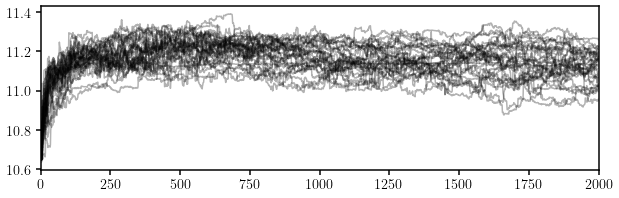

In [17]:
fig = plt.figure(figsize=(10,3))
sub = fig.add_subplot(111)
sub.plot(mcmc_chain['mcmc_chain'][:,:,0], 'k', alpha=0.3)
sub.set_xlim(0, mcmc_chain['mcmc_chain'].shape[0])